In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit_machine_learning.neural_networks import SamplerQNN

# IBM Cloud
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit import transpile 

In [39]:
TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

#PCA FEATURES
N_DIM = 8
LIMIT_PER_PATIENT = 600

NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

In [40]:
def load_patient_data(patiend_id):
    ekg_file = f'archive/{patiend_id}_ekg.csv'
    ann_file = f'archive/{patiend_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('nie ma pliku')
        return [], []
    
    # load ekg signal
    df_ekg = pd.read_csv(ekg_file)
    # Delete spaces between columns
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
                signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # If no name provided take 1st column
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    den = np.max(signal) - np.min(signal)
    if den == 0:
        return [], []
    signal = (signal - np.min(signal)) / den
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Czyścimy nazwy
            
        # Search for sample, symbol
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  No columns sample or symbol")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Skip beats on signals edge
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # window
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # TXT length check
        if len(window) != WINDOW_SIZE:
            continue

        # Classification
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Found: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

>>> STEP 1: Load train data (Healthy)...
  -> Found: 600 Normal, 34 Anomaly
  -> Found: 600 Normal, 3 Anomaly
  -> Found: 99 Normal, 600 Anomaly

>>> STEP 2: Load train data (Healthy + Arrhythmia)...
  -> Found: 600 Normal, 520 Anomaly
  -> Found: 600 Normal, 444 Anomaly

RAW DATA:
Size of single heartbeat: 90 samples
Number of samples Train (Normal): 1299
Number of samples Test (Normal): 1200
Number of samples Test (Anomaly): 964

>>> STEP 3: Dimension reduction (PCA) from 90 to 8...
Variancy (How much information we've kept): 99.48%
>>> STEP 4: Scaling (0, pi)...
PCA and Scaler saved to: preprocessing_8dim.joblib

>>> STEP 5: Saving files .npy...
Saving done

>>> Generating chart


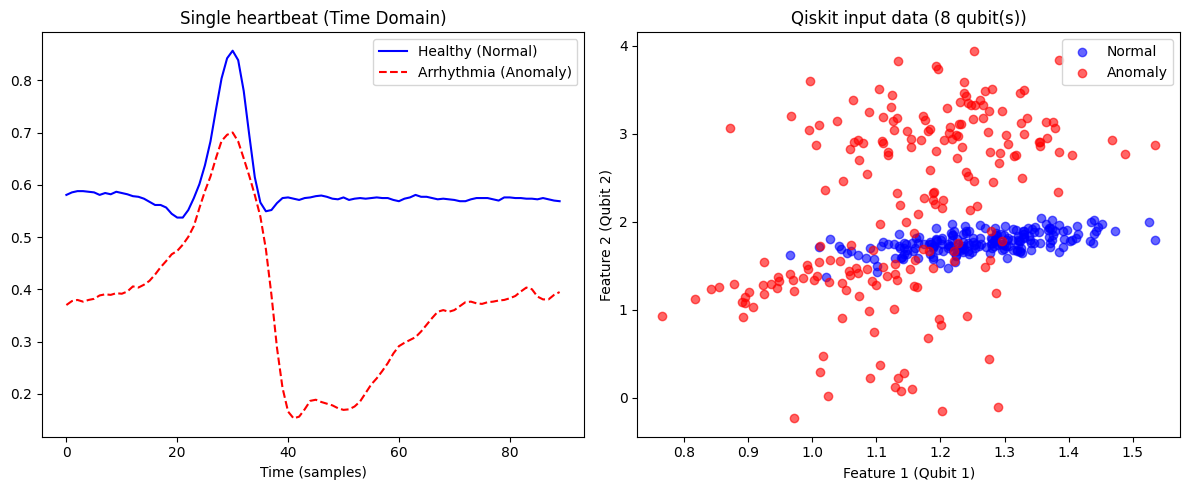

In [41]:
all_train_normal = []
all_test_normal = []
all_test_anomaly = []

print(">>> STEP 1: Load train data (Healthy)...")
for pid in TRAIN_PATIENTS:
    n, _ = load_patient_data(pid)
    all_train_normal.extend(n)

print("\n>>> STEP 2: Load train data (Healthy + Arrhythmia)...")
for pid in TEST_PATIENTS:
    n, a = load_patient_data(pid)
    all_test_normal.extend(n)
    all_test_anomaly.extend(a)

# Konwersja na numpy array
X_train = np.array(all_train_normal)
X_test_normal = np.array(all_test_normal)
X_test_anomaly = np.array(all_test_anomaly)

print(f"\nRAW DATA:")
print(f"Size of single heartbeat: {WINDOW_SIZE} samples")
print(f"Number of samples Train (Normal): {X_train.shape[0]}")
print(f"Number of samples Test (Normal): {X_test_normal.shape[0]}")
print(f"Number of samples Test (Anomaly): {X_test_anomaly.shape[0]}")

if len(X_train) == 0:
    print("CRITICAL ERROR: No training data. Check CSV!")
    raise ValueError

# PCA processing
print(f"\n>>> STEP 3: Dimension reduction (PCA) from {WINDOW_SIZE} to {N_DIM}...")

# Training on normal data
pca = PCA(n_components=N_DIM)
pca.fit(X_train)

# Datasets transformation
X_train_pca = pca.transform(X_train)
X_test_normal_pca = pca.transform(X_test_normal)

# No anomaly exception
if len(X_test_anomaly) > 0:
    X_test_anomaly_pca = pca.transform(X_test_anomaly)
else:
    X_test_anomaly_pca = np.empty((0, N_DIM))

print(f"Variancy (How much information we've kept): {sum(pca.explained_variance_ratio_):.2%}")

# Transformation classic -> quantum
print(">>> STEP 4: Scaling (0, pi)...")

scaler = MinMaxScaler(feature_range=(0, np.pi))
scaler.fit(X_train_pca) # Scaler training

joblib.dump(
    {
    "pca": pca,
    "scaler": scaler,
    "n_dim": N_DIM,
    "window_size": WINDOW_SIZE
    },
    "ibm_preprocessing_8dim.joblib"
)
print("PCA and Scaler saved to: preprocessing_8dim.joblib")

X_train_final = scaler.transform(X_train_pca)
X_test_normal_final = scaler.transform(X_test_normal_pca)

if len(X_test_anomaly) > 0:
    X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
else:
    X_test_anomaly_final = X_test_anomaly_pca

# FILES SAVE
print("\n>>> STEP 5: Saving files .npy...")
np.save('train_data.npy', X_train_final)
np.save('test_normal.npy', X_test_normal_final)
np.save('test_anomaly.npy', X_test_anomaly_final)
print("Saving done")

# VISUALISATION
print("\n>>> Generating chart")
plt.figure(figsize=(12, 5))

# Raw beat
plt.subplot(1, 2, 1)
plt.plot(X_train[0], label='Healthy (Normal)', color='blue')
if len(X_test_anomaly) > 0:
    plt.plot(X_test_anomaly[0], label='Arrhythmia (Anomaly)', color='red', linestyle='--')
plt.title("Single heartbeat (Time Domain)")
plt.xlabel("Time (samples)")
plt.legend()

# After PCA
plt.subplot(1, 2, 2)
# only 100 dots for a clear view
plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
            c='blue', alpha=0.6, label='Normal')
if len(X_test_anomaly_final) > 0:
    plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                c='red', alpha=0.6, label='Anomaly')
plt.title(f"Qiskit input data ({N_DIM} qubit(s))")
plt.xlabel("Feature 1 (Qubit 1)")
plt.ylabel("Feature 2 (Qubit 2)")
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3754429299.py:25: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3754429299.py:26: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


>>> 1. Loading data (8 features)...
    Training on: 1299 samples
>>> 2. Building circuit (8 qubits)...
>>> 3. Training start (Optimizer: SPSA, Iter: 100)...
    Iter 10: Koszt = 0.4309
    Iter 20: Koszt = 0.3953
    Iter 30: Koszt = 0.6119
    Iter 40: Koszt = 0.3564
    Iter 50: Koszt = 0.5957
    Iter 60: Koszt = 0.3185
    Iter 70: Koszt = 0.1287
    Iter 80: Koszt = 0.0911
    Iter 90: Koszt = 0.1194
    Iter 100: Koszt = 0.1560
    Iter 110: Koszt = 0.1675
    Iter 120: Koszt = 0.0793
    Iter 130: Koszt = 0.0955
    Iter 140: Koszt = 0.0773
    Iter 150: Koszt = 0.1033
    Iter 160: Koszt = 0.1022
    Iter 170: Koszt = 0.0747
    Iter 180: Koszt = 0.0515
    Iter 190: Koszt = 0.0373
    Iter 200: Koszt = 0.0846
    Iter 210: Koszt = 0.0662
    Iter 220: Koszt = 0.0624
    Iter 230: Koszt = 0.0781
    Iter 240: Koszt = 0.0966
    Iter 250: Koszt = 0.0499
>>> Training time: 108.8 s
>>> Optimalization score: fun=0.059947
>>> 4. Scores generating...


C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3754429299.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


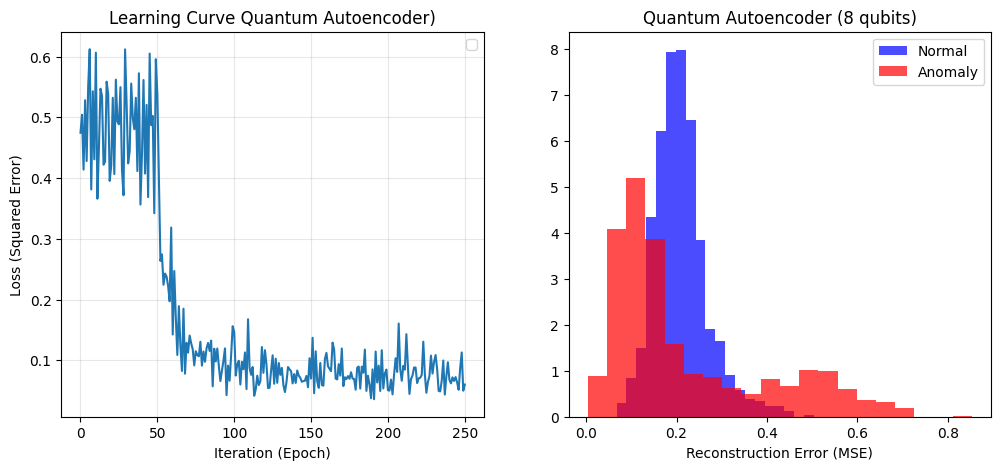

In [ ]:
INPUT_DIM = N_DIM     # 8 features
MAX_ITER = 100     
BATCH_SIZE = 25 
EVAL_BATCH = 50

print(f">>> 1. Loading data (8 features)...")
try:
    train_data = np.load('train_data.npy')
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError as e:
    raise FileNotFoundError("Error: No train or test files!") from e

if train_data.ndim != 2:
    raise ValueError(f"""ERROR: Train data {train_data.ndim}, 
                     need 2D matrix (n_samples, n_fueatures).""")
if train_data.shape[1] != INPUT_DIM:
    raise ValueError(f"""ERROR: Train data: {train_data.shape[1]},
                     code needs {INPUT_DIM}.""")

print(f"    Training on: {len(train_data)} samples")

# Quantum circuit
print(">>> 2. Building circuit (8 qubits)...")
feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')

qc = QuantumCircuit(INPUT_DIM)
qc.append(feature_map, range(INPUT_DIM))
qc.append(ansatz, range(INPUT_DIM))

def parity(x: int) -> int:
    return x % 2

qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2
)

# Training
objective_func_vals = []

def cost_func(params_values):
    BS = min(BATCH_SIZE, len(train_data))
    batch_idx = np.random.choice(len(train_data), BS, replace=False)
    batch_data = train_data[batch_idx]
    
    probs = qnn.forward(batch_data, params_values)
    p1 = np.clip(probs[:, 1], 1e-4, 1.0 - 1e-4)
    loss = float(np.mean(p1))

    objective_func_vals.append(loss)
    if len(objective_func_vals) % 10 == 0:
        print(f"    Iter {len(objective_func_vals)}: Koszt = {loss:.4f}")
    return loss

print(f">>> 3. Training start (Optimizer: SPSA, Iter: {MAX_ITER})...")

# optimizer = COBYLA(maxiter=MAX_ITER) 

# lr=0.01 "learning rate"
#optimizer = ADAM(maxiter=MAX_ITER, lr=0.01) 

optimizer = SPSA(maxiter=MAX_ITER)
initial_weights = 0.1 * (2 * np.random.random(ansatz.num_parameters) - 1)

start_t = time.time()
result = optimizer.minimize(fun=cost_func, x0=initial_weights)
print(f">>> Training time: {time.time() - start_t:.1f} s")
print(f">>> Optimalization score: fun={result.fun:.6f}")

# Results
print(">>> 4. Scores generating...")
trained_weights = result.x

# Evaluation function
def get_scores_anomaly_prob(data):
    """ 
     score = p1 (probability of class 1 = 'anomaly'  (QNN). 
    """
    scores = []
    for i in range(0, len(data), EVAL_BATCH): # Smaller batches for 8 qubits
        batch = data[i:i+EVAL_BATCH]
        p = qnn.forward(batch, trained_weights)
        p1 = p[:, 1]
        scores.extend(p1.tolist())
    return np.array(scores, dtype=float)

s_norm = get_scores_anomaly_prob(test_normal)
s_anom = get_scores_anomaly_prob(test_anomaly)

# VISUALISATION
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(objective_func_vals)
plt.title(f"Learning Curve Quantum Autoencoder)")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Loss (Squared Error)")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(s_norm, bins=20, alpha=0.7, color='Blue', label='Normal', density=True)
plt.hist(s_anom, bins=20, alpha=0.7, color='Red', label='Anomaly', density=True)
plt.title("Quantum Autoencoder (8 qubits)")
plt.xlabel("Reconstruction Error (MSE)")
plt.legend()

plt.savefig("result_images/results_8qubits_main_results.png")
plt.show()

In [43]:
scores = np.concatenate([s_norm, s_anom])
y_true = np.array([0]*len(s_norm) + [1]*len(s_anom))

def best_threshold(rule="greater"):
    # rule="greater": anomaly if score > t
    # rule="less": anomaly if score < t
    ts = np.quantile(scores, np.linspace(0.01, 0.99, 200))
    best = (-1, None)
    for t in ts:
        if rule == "greater":
            y_pred = (scores > t).astype(int)
        else:
            y_pred = (scores < t).astype(int)
        acc = accuracy_score(y_true, y_pred)
        if acc > best[0]:
            best = (acc, t)
    return best

acc_g, t_g = best_threshold("greater")
acc_l, t_l = best_threshold("less")

print("Best rule score > t:", acc_g, "t =", t_g)
print("Best rule score < t:", acc_l, "t =", t_l)

print("Means:", "mean_norm=", np.mean(s_norm), "mean_anom=", np.mean(s_anom))


Best rule score > t: 0.6432532347504621 t = 0.35280359341965734
Best rule score < t: 0.7273567467652495 t = 0.1453735004766312
Means: mean_norm= 0.20952112179188287 mean_anom= 0.22221812113474965



>>> Confusion matrix generation...
     Scores for 0.14     
Accuracy: 80.82%
Precision:  84.62% (How much detected arrhythias are actually arrhythmias?)
Recall:      69.61% (How many arrhythmias were detected?)


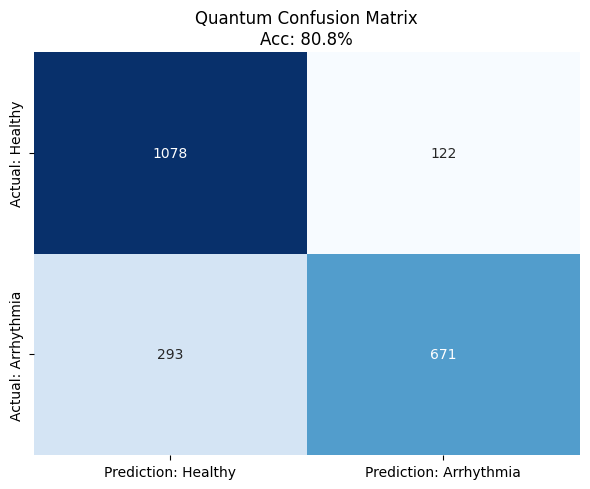

In [ ]:
# CONFUSION MATRIX
print("\n>>> Confusion matrix generation...")

# Threshold set
THRESHOLD = 0.14
THRESHOLD2 = 0.38

# (Ground Truth)
# 0 = Healthy (Normal), 1 = Arrhythmia (Anomaly)
y_true = [0] * len(s_norm) + [1] * len(s_anom)

# Model prediction
# We need to flip the logic
# If score < THRESHOLD -> Arrhythmia (1)
# If score > THRESHOLD -> Healthy (0)

y_pred = []
# Healthy score
for score in s_norm:
    prediction = 1 if (score < THRESHOLD or score > THRESHOLD2) else 0
    y_pred.append(prediction)

# Anomaly score
for score in s_anom:
    prediction = 1 if (score < THRESHOLD or score > THRESHOLD2) else 0
    y_pred.append(prediction)

# Metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"     Scores for {THRESHOLD}     ")
print(f"Accuracy: {acc:.2%}")
print(f"Precision:  {prec:.2%} (How much detected arrhythias are actually arrhythmias?)")
print(f"Recall:      {rec:.2%} (How many arrhythmias were detected?)")

# 5. Matrix (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Prediction: Healthy', 'Prediction: Arrhythmia'],
            yticklabels=['Actual: Healthy', 'Actual: Arrhythmia'])
plt.title(f'Quantum Confusion Matrix\nAcc: {acc:.1%}')

plt.tight_layout()
plt.savefig("result_images/confusion_matrix_main_results.png")
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score

def prepare_data_for_run(train_pids, test_pids, limit_per_patient, n_dim=N_DIM):
    
    global LIMIT_PER_PATIENT
    LIMIT_PER_PATIENT = int(limit_per_patient)

    # load data
    all_train_normal = []
    all_test_normal = []
    all_test_anomaly = []

    print(f"\n=== PREPARE: train={train_pids} | test={test_pids} | limit={LIMIT_PER_PATIENT} ===")

    print(">>> STEP 1: Loadning train data (Healthy)...")
    for pid in train_pids:
        n, _ = load_patient_data(pid)
        all_train_normal.extend(n)

    print(">>> STEP 2: Loading test data (Healthy + Anomaly)...")
    for pid in test_pids:
        n, a = load_patient_data(pid)
        all_test_normal.extend(n)
        all_test_anomaly.extend(a)

    X_train = np.array(all_train_normal)
    X_test_normal = np.array(all_test_normal)
    X_test_anomaly = np.array(all_test_anomaly)

    print("RAW DATA:")
    print(f"  WINDOW_SIZE: {WINDOW_SIZE}")
    print(f"  Train (Normal): {len(X_train)}")
    print(f"  Test  (Normal): {len(X_test_normal)}")
    print(f"  Test  (Anomaly): {len(X_test_anomaly)}")

    if len(X_train) == 0:
        print("  [SKIP] No train data.")
        return None
    if len(X_test_normal) == 0 or len(X_test_anomaly) == 0:
        print("  [SKIP] No test data.")
        return None

    # --- PCA ---
    print(f">>> STEP 3: PCA from {WINDOW_SIZE} to {n_dim}...")
    pca = PCA(n_components=n_dim)
    pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_normal_pca = pca.transform(X_test_normal)
    X_test_anomaly_pca = pca.transform(X_test_anomaly)

    explained = float(np.sum(pca.explained_variance_ratio_))
    print(f"  PCA explained variance: {explained:.2%}")

    # --- scaler (0, pi) ---
    print(">>> STEP 4: Scaling to (0, pi)...")
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    scaler.fit(X_train_pca)

    train_data = scaler.transform(X_train_pca)
    test_normal = scaler.transform(X_test_normal_pca)
    test_anomaly = scaler.transform(X_test_anomaly_pca)

    return train_data, test_normal, test_anomaly, explained


In [46]:
def train_and_eval_one_run(train_data, test_normal, test_anomaly):
  
    INPUT_DIM = N_DIM
    MAX_ITER = 100
    BATCH_SIZE = 25
    EVAL_BATCH = 50

    print(f">>> TRAIN: {len(train_data)} samples | qubits={INPUT_DIM} | iter={MAX_ITER}")

    # QC
    feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
    ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')

    qc = QuantumCircuit(INPUT_DIM)
    qc.append(feature_map, range(INPUT_DIM))
    qc.append(ansatz, range(INPUT_DIM))

    def parity(x: int) -> int:
        return x % 2

    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        interpret=parity,
        output_shape=2
    )

    objective_func_vals = []

    def cost_func(params_values):
        BS = min(BATCH_SIZE, len(train_data))
        batch_idx = np.random.choice(len(train_data), BS, replace=False)
        batch_data = train_data[batch_idx]

        probs = qnn.forward(batch_data, params_values)
        p1 = np.clip(probs[:, 1], 1e-4, 1.0 - 1e-4)
        loss = float(np.mean(p1))

        objective_func_vals.append(loss)
        if len(objective_func_vals) % 10 == 0:
            print(f"    Iter {len(objective_func_vals)}: Cost = {loss:.4f}")
        return loss

    optimizer = SPSA(maxiter=MAX_ITER)
    initial_weights = 0.1 * (2 * np.random.random(ansatz.num_parameters) - 1)

    start_t = time.time()
    result = optimizer.minimize(fun=cost_func, x0=initial_weights)
    train_time_s = time.time() - start_t

    trained_weights = result.x
    final_loss = float(result.fun)

    # scoring 
    def get_scores_anomaly_prob(data):
        scores = []
        for i in range(0, len(data), EVAL_BATCH):
            batch = data[i:i+EVAL_BATCH]
            p = qnn.forward(batch, trained_weights)
            scores.extend(p[:, 1].tolist())  # p1
        return np.array(scores, dtype=float)

    s_norm = get_scores_anomaly_prob(test_normal)
    s_anom = get_scores_anomaly_prob(test_anomaly)
    from sklearn.metrics import accuracy_score
    
    def best_threshold_from_scores(s_norm, s_anom):
        scores = np.concatenate([s_norm, s_anom])
        y_true = np.array([0]*len(s_norm) + [1]*len(s_anom))

        ts = np.quantile(scores, np.linspace(0.01, 0.99, 200))

        best_acc = -1.0
        best_t = None
        best_rule = None

        # rule="greater": anomaly if score > t
        for t in ts:
            y_pred = (scores > t).astype(int)
            acc = accuracy_score(y_true, y_pred)
            if acc > best_acc:
                best_acc, best_t, best_rule = acc, float(t), "greater"

        # rule="less": anomaly if score < t
        for t in ts:
            y_pred = (scores < t).astype(int)
            acc = accuracy_score(y_true, y_pred)
            if acc > best_acc:
                best_acc, best_t, best_rule = acc, float(t), "less"

        return best_acc, best_t, best_rule

    acc_best, thr_best, rule_best = best_threshold_from_scores(s_norm, s_anom)
    print("Best-threshold:", acc_best, "thr=", thr_best, "rule=", rule_best)

    # metrics
    y_true = np.r_[np.zeros(len(s_norm)), np.ones(len(s_anom))]
    scores_all = np.r_[s_norm, s_anom]

    auc = float(roc_auc_score(y_true, scores_all))

    # TPR@FPR=5% (operating point)
    thr = float(np.quantile(s_norm, 0.95))  # FPR target 5%
    tpr_at_fpr = float(np.mean(s_anom >= thr))

    return {
    "final_loss": final_loss,
    "train_time_s": train_time_s,
    "roc_auc": auc,
    "tpr@fpr": tpr_at_fpr,
    "threshold": thr,
    "mean_norm": float(np.mean(s_norm)),
    "mean_anom": float(np.mean(s_anom)),
    "n_train": int(len(train_data)),
    "n_test_norm": int(len(test_normal)),
    "n_test_anom": int(len(test_anomaly)),
    "acc_best": float(acc_best),
    "thr_best": float(thr_best),
    "rule_best": str(rule_best),
    "s_norm": s_norm,
    "s_anom": s_anom,
}



In [47]:
TRAIN_SETS = [
    ["100"],
    ["100", "101"],
    ["100", "101", "102"],
    ["100", "101", "102", "103", "104"],
]
TEST_SET = ["106", "119"]
LIMIT_GRID = [200, 600]

rows = []
run_id = 0

for train_pids in TRAIN_SETS:
    for limit_val in LIMIT_GRID:
        prep = prepare_data_for_run(train_pids, TEST_SET, limit_val, n_dim=N_DIM)
        if prep is None:
            continue

        train_data, test_normal, test_anomaly, explained = prep

        out = train_and_eval_one_run(train_data, test_normal, test_anomaly)

        run_id += 1
        out["run_id"] = run_id
        out["train_pids"] = ",".join(train_pids)
        out["train_patients_n"] = len(train_pids)
        out["test_pids"] = ",".join(TEST_SET)
        out["limit_per_patient"] = int(limit_val)
        out["pca_explained"] = float(explained)

        rows.append(out)

df_scal = pd.DataFrame(rows)
df_scal



=== PREPARE: train=['100'] | test=['106', '119'] | limit=200 ===
>>> STEP 1: Loadning train data (Healthy)...
  -> Found: 200 Normal, 34 Anomaly
>>> STEP 2: Loading test data (Healthy + Anomaly)...
  -> Found: 200 Normal, 200 Anomaly


C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Found: 200 Normal, 200 Anomaly
RAW DATA:
  WINDOW_SIZE: 90
  Train (Normal): 200
  Test  (Normal): 400
  Test  (Anomaly): 400
>>> STEP 3: PCA from 90 to 8...
  PCA explained variance: 97.48%
>>> STEP 4: Scaling to (0, pi)...
>>> TRAIN: 200 samples | qubits=8 | iter=100
    Iter 10: Cost = 0.5738
    Iter 20: Cost = 0.4856
    Iter 30: Cost = 0.5093
    Iter 40: Cost = 0.5358
    Iter 50: Cost = 0.4617
    Iter 60: Cost = 0.3711
    Iter 70: Cost = 0.4065
    Iter 80: Cost = 0.2918
    Iter 90: Cost = 0.3012
    Iter 100: Cost = 0.2604
    Iter 110: Cost = 0.3023
    Iter 120: Cost = 0.4134
    Iter 130: Cost = 0.2635
    Iter 140: Cost = 0.2771
    Iter 150: Cost = 0.2659
    Iter 160: Cost = 0.3502
    Iter 170: Cost = 0.3870
    Iter 180: Cost = 0.2829
    Iter 190: Cost = 0.2827
    Iter 200: Cost = 0.2520
    Iter 210: Cost = 0.2148
    Iter 220: Cost = 0.2809
    Iter 230: Cost = 0.2875
    Iter 240: Cost = 0.2575
    Iter 250: Cost = 0.2473
Best-threshold: 0.5225 thr= 0.9569

C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Found: 600 Normal, 520 Anomaly
  -> Found: 600 Normal, 444 Anomaly
RAW DATA:
  WINDOW_SIZE: 90
  Train (Normal): 600
  Test  (Normal): 1200
  Test  (Anomaly): 964
>>> STEP 3: PCA from 90 to 8...
  PCA explained variance: 97.60%
>>> STEP 4: Scaling to (0, pi)...
>>> TRAIN: 600 samples | qubits=8 | iter=100
    Iter 10: Cost = 0.4827
    Iter 20: Cost = 0.4294
    Iter 30: Cost = 0.4129
    Iter 40: Cost = 0.4501
    Iter 50: Cost = 0.4947
    Iter 60: Cost = 0.3970
    Iter 70: Cost = 0.2464
    Iter 80: Cost = 0.2262
    Iter 90: Cost = 0.2083
    Iter 100: Cost = 0.1952
    Iter 110: Cost = 0.1547
    Iter 120: Cost = 0.1977
    Iter 130: Cost = 0.1589
    Iter 140: Cost = 0.2028
    Iter 150: Cost = 0.1698
    Iter 160: Cost = 0.1976
    Iter 170: Cost = 0.1472
    Iter 180: Cost = 0.2216
    Iter 190: Cost = 0.3002
    Iter 200: Cost = 0.2356
    Iter 210: Cost = 0.2059
    Iter 220: Cost = 0.1859
    Iter 230: Cost = 0.1751
    Iter 240: Cost = 0.2413
    Iter 250: Cost = 0.16

C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Found: 200 Normal, 200 Anomaly
RAW DATA:
  WINDOW_SIZE: 90
  Train (Normal): 400
  Test  (Normal): 400
  Test  (Anomaly): 400
>>> STEP 3: PCA from 90 to 8...
  PCA explained variance: 99.22%
>>> STEP 4: Scaling to (0, pi)...
>>> TRAIN: 400 samples | qubits=8 | iter=100
    Iter 10: Cost = 0.4332
    Iter 20: Cost = 0.4360
    Iter 30: Cost = 0.5617
    Iter 40: Cost = 0.5694
    Iter 50: Cost = 0.4033
    Iter 60: Cost = 0.2748
    Iter 70: Cost = 0.1925
    Iter 80: Cost = 0.1880
    Iter 90: Cost = 0.2546
    Iter 100: Cost = 0.1364
    Iter 110: Cost = 0.1461
    Iter 120: Cost = 0.1623
    Iter 130: Cost = 0.1966
    Iter 140: Cost = 0.1417
    Iter 150: Cost = 0.1018
    Iter 160: Cost = 0.1449
    Iter 170: Cost = 0.1093
    Iter 180: Cost = 0.1722
    Iter 190: Cost = 0.2000
    Iter 200: Cost = 0.1766
    Iter 210: Cost = 0.1657
    Iter 220: Cost = 0.0995
    Iter 230: Cost = 0.2216
    Iter 240: Cost = 0.1738
    Iter 250: Cost = 0.1493
Best-threshold: 0.77 thr= 0.810342

C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Found: 600 Normal, 444 Anomaly
RAW DATA:
  WINDOW_SIZE: 90
  Train (Normal): 1200
  Test  (Normal): 1200
  Test  (Anomaly): 964
>>> STEP 3: PCA from 90 to 8...
  PCA explained variance: 99.34%
>>> STEP 4: Scaling to (0, pi)...
>>> TRAIN: 1200 samples | qubits=8 | iter=100
    Iter 10: Cost = 0.3542
    Iter 20: Cost = 0.5200
    Iter 30: Cost = 0.4638
    Iter 40: Cost = 0.4890
    Iter 50: Cost = 0.5184
    Iter 60: Cost = 0.3886
    Iter 70: Cost = 0.3104
    Iter 80: Cost = 0.2069
    Iter 90: Cost = 0.2162
    Iter 100: Cost = 0.1719
    Iter 110: Cost = 0.1741
    Iter 120: Cost = 0.1862
    Iter 130: Cost = 0.1466
    Iter 140: Cost = 0.1521
    Iter 150: Cost = 0.1443
    Iter 160: Cost = 0.1014
    Iter 170: Cost = 0.1031
    Iter 180: Cost = 0.1111
    Iter 190: Cost = 0.0876
    Iter 200: Cost = 0.1207
    Iter 210: Cost = 0.0889
    Iter 220: Cost = 0.1013
    Iter 230: Cost = 0.0904
    Iter 240: Cost = 0.0882
    Iter 250: Cost = 0.1237
Best-threshold: 0.8387245841035

C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Found: 200 Normal, 200 Anomaly
  -> Found: 200 Normal, 200 Anomaly
RAW DATA:
  WINDOW_SIZE: 90
  Train (Normal): 499
  Test  (Normal): 400
  Test  (Anomaly): 400
>>> STEP 3: PCA from 90 to 8...
  PCA explained variance: 99.50%
>>> STEP 4: Scaling to (0, pi)...
>>> TRAIN: 499 samples | qubits=8 | iter=100
    Iter 10: Cost = 0.4499
    Iter 20: Cost = 0.5225
    Iter 30: Cost = 0.5100
    Iter 40: Cost = 0.5484
    Iter 50: Cost = 0.4711
    Iter 60: Cost = 0.3041
    Iter 70: Cost = 0.2924
    Iter 80: Cost = 0.2938
    Iter 90: Cost = 0.1835
    Iter 100: Cost = 0.2135
    Iter 110: Cost = 0.2422
    Iter 120: Cost = 0.1599
    Iter 130: Cost = 0.2039
    Iter 140: Cost = 0.1507
    Iter 150: Cost = 0.1977
    Iter 160: Cost = 0.1923
    Iter 170: Cost = 0.1081
    Iter 180: Cost = 0.1432
    Iter 190: Cost = 0.1787
    Iter 200: Cost = 0.1787
    Iter 210: Cost = 0.2352
    Iter 220: Cost = 0.2036
    Iter 230: Cost = 0.1889
    Iter 240: Cost = 0.1958
    Iter 250: Cost = 0.140

C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Found: 600 Normal, 520 Anomaly
  -> Found: 600 Normal, 444 Anomaly
RAW DATA:
  WINDOW_SIZE: 90
  Train (Normal): 1299
  Test  (Normal): 1200
  Test  (Anomaly): 964
>>> STEP 3: PCA from 90 to 8...
  PCA explained variance: 99.48%
>>> STEP 4: Scaling to (0, pi)...
>>> TRAIN: 1299 samples | qubits=8 | iter=100
    Iter 10: Cost = 0.4576
    Iter 20: Cost = 0.5897
    Iter 30: Cost = 0.4798
    Iter 40: Cost = 0.4727
    Iter 50: Cost = 0.3299
    Iter 60: Cost = 0.2057
    Iter 70: Cost = 0.2144
    Iter 80: Cost = 0.1696
    Iter 90: Cost = 0.1009
    Iter 100: Cost = 0.0816
    Iter 110: Cost = 0.1002
    Iter 120: Cost = 0.0526
    Iter 130: Cost = 0.1170
    Iter 140: Cost = 0.0684
    Iter 150: Cost = 0.0575
    Iter 160: Cost = 0.0679
    Iter 170: Cost = 0.0594
    Iter 180: Cost = 0.0497
    Iter 190: Cost = 0.0681
    Iter 200: Cost = 0.0787
    Iter 210: Cost = 0.0919
    Iter 220: Cost = 0.1019
    Iter 230: Cost = 0.0829
    Iter 240: Cost = 0.0842
    Iter 250: Cost = 0.

C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Found: 200 Normal, 200 Anomaly
  -> Found: 200 Normal, 200 Anomaly
RAW DATA:
  WINDOW_SIZE: 90
  Train (Normal): 862
  Test  (Normal): 400
  Test  (Anomaly): 400
>>> STEP 3: PCA from 90 to 8...
  PCA explained variance: 99.57%
>>> STEP 4: Scaling to (0, pi)...
>>> TRAIN: 862 samples | qubits=8 | iter=100
    Iter 10: Cost = 0.5729
    Iter 20: Cost = 0.4927
    Iter 30: Cost = 0.5356
    Iter 40: Cost = 0.4964
    Iter 50: Cost = 0.5706
    Iter 60: Cost = 0.3286
    Iter 70: Cost = 0.2698
    Iter 80: Cost = 0.3632
    Iter 90: Cost = 0.2459
    Iter 100: Cost = 0.2471
    Iter 110: Cost = 0.3096
    Iter 120: Cost = 0.2850
    Iter 130: Cost = 0.3712
    Iter 140: Cost = 0.3156
    Iter 150: Cost = 0.3129
    Iter 160: Cost = 0.2883
    Iter 170: Cost = 0.2926
    Iter 180: Cost = 0.3673
    Iter 190: Cost = 0.3413
    Iter 200: Cost = 0.2817
    Iter 210: Cost = 0.2918
    Iter 220: Cost = 0.3336
    Iter 230: Cost = 0.2396
    Iter 240: Cost = 0.2735
    Iter 250: Cost = 0.424

C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Shehoyo\AppData\Local\Temp\ipykernel_31108\3025367531.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Found: 600 Normal, 520 Anomaly
  -> Found: 600 Normal, 444 Anomaly
RAW DATA:
  WINDOW_SIZE: 90
  Train (Normal): 2062
  Test  (Normal): 1200
  Test  (Anomaly): 964
>>> STEP 3: PCA from 90 to 8...
  PCA explained variance: 99.73%
>>> STEP 4: Scaling to (0, pi)...
>>> TRAIN: 2062 samples | qubits=8 | iter=100
    Iter 10: Cost = 0.4038
    Iter 20: Cost = 0.6159
    Iter 30: Cost = 0.4345
    Iter 40: Cost = 0.3982
    Iter 50: Cost = 0.5587
    Iter 60: Cost = 0.1622
    Iter 70: Cost = 0.1554
    Iter 80: Cost = 0.1677
    Iter 90: Cost = 0.1551
    Iter 100: Cost = 0.1997
    Iter 110: Cost = 0.1816
    Iter 120: Cost = 0.1564
    Iter 130: Cost = 0.1338
    Iter 140: Cost = 0.1718
    Iter 150: Cost = 0.1278
    Iter 160: Cost = 0.1678
    Iter 170: Cost = 0.1572
    Iter 180: Cost = 0.1589
    Iter 190: Cost = 0.1371
    Iter 200: Cost = 0.1666
    Iter 210: Cost = 0.1548
    Iter 220: Cost = 0.1411
    Iter 230: Cost = 0.1119
    Iter 240: Cost = 0.1634
    Iter 250: Cost = 0.

,final_loss,train_time_s,roc_auc,tpr@fpr,threshold,mean_norm,mean_anom,n_train,n_test_norm,n_test_anom,...,thr_best,rule_best,s_norm,s_anom,run_id,train_pids,train_patients_n,test_pids,limit_per_patient,pca_explained
0,0.236474,120.589770,0.487087,0.037500,0.991403,0.558349,0.545615,200,400,400,...,0.956945,less,"[0.9774034671245317, 0.21507202056636743, 0.62...","[0.026501961903704796, 0.07483735312052886, 0....",1,100,1,"106,119",200,0.974785
1,0.224506,118.466362,0.306391,0.017635,0.953739,0.696377,0.486835,600,1200,964,...,0.504508,less,"[0.9074453683570027, 0.6521048383583548, 0.797...","[0.39253244866813475, 0.5240884960439871, 0.54...",2,100,1,"106,119",600,0.976017
2,0.103836,106.863157,0.167069,0.005000,0.994758,0.929482,0.709209,400,400,400,...,0.810343,less,"[0.9134319384193077, 0.8698611361814983, 0.874...","[0.8269501734830556, 0.9603210062341532, 0.909...",3,"100,101",2,"106,119",200,0.992157
3,0.060881,113.703910,0.133308,0.026971,0.517889,0.371295,0.163296,1200,1200,964,...,0.180569,less,"[0.3808391080056026, 0.3760420540929772, 0.353...","[0.531390852685945, 0.08242608307045884, 0.232...",4,"100,101",2,"106,119",600,0.993353
4,0.149869,113.901649,0.227381,0.012500,0.952576,0.752509,0.443339,499,400,400,...,0.468154,less,"[0.9083127057729143, 0.6904650742981175, 0.827...","[0.9297682806227385, 0.9076694410996424, 0.944...",5,"100,101,102",3,"106,119",200,0.994958
5,0.051633,115.029776,0.369156,0.246888,0.316963,0.209833,0.217114,1299,1200,964,...,0.140074,less,"[0.1401139979261643, 0.20191663900004642, 0.14...","[0.2990616701190447, 0.3792327019946242, 0.110...",6,"100,101,102",3,"106,119",600,0.994813
6,0.289723,121.203739,0.237844,0.075000,0.834650,0.657506,0.389588,862,400,400,...,0.471734,less,"[0.6760057348037662, 0.6178147373957472, 0.619...","[0.8339501669470337, 0.7071363033810485, 0.786...",7,"100,101,102,103,104",5,"106,119",200,0.995734
7,0.163372,119.345598,0.264182,0.057054,0.333879,0.183038,0.108601,2062,1200,964,...,0.059059,less,"[0.19492090613675828, 0.1494830454212206, 0.15...","[0.3113604975205817, 0.17030766853531532, 0.25...",8,"100,101,102,103,104",5,"106,119",600,0.997318


In [48]:
# ROC
tbl = df_scal

# save original
if "roc_auc_raw" not in tbl.columns:
    tbl["roc_auc_raw"] = tbl["roc_auc"]

# (max(AUC, 1-AUC))
tbl["roc_auc_fixed"] = np.where(
    tbl["roc_auc_raw"] < 0.5,
    1.0 - tbl["roc_auc_raw"],
    tbl["roc_auc_raw"]
)

tbl["roc_flipped"] = tbl["roc_auc_raw"] < 0.5


tbl["roc_auc"] = tbl["roc_auc_fixed"]

# preview
tbl[[
    "train_patients_n",
    "limit_per_patient",
    "roc_auc_raw",
    "roc_auc",         
    "roc_auc_fixed",
    "roc_flipped"
]].sort_values(["train_patients_n", "limit_per_patient"])


,train_patients_n,limit_per_patient,roc_auc_raw,roc_auc,roc_auc_fixed,roc_flipped
0,1,200,0.487087,0.512913,0.512913,True
1,1,600,0.306391,0.693609,0.693609,True
2,2,200,0.167069,0.832931,0.832931,True
3,2,600,0.133308,0.866692,0.866692,True
4,3,200,0.227381,0.772619,0.772619,True
5,3,600,0.369156,0.630844,0.630844,True
6,5,200,0.237844,0.762156,0.762156,True
7,5,600,0.264182,0.735818,0.735818,True


In [49]:
summary = (df_scal
           .groupby(["train_patients_n", "limit_per_patient"])
           .agg(
               roc_auc=("roc_auc", "mean"),
               tpr_at_fpr=("tpr@fpr", "mean"),
               train_time_s=("train_time_s", "mean"),
               final_loss=("final_loss", "mean"),
               pca_explained=("pca_explained", "mean"),
               n_train=("n_train", "mean"),
           )
           .reset_index()
          )

summary


,train_patients_n,limit_per_patient,roc_auc,tpr_at_fpr,train_time_s,final_loss,pca_explained,n_train
0,1,200,0.512913,0.037500,120.589770,0.236474,0.974785,200.0
1,1,600,0.693609,0.017635,118.466362,0.224506,0.976017,600.0
2,2,200,0.832931,0.005000,106.863157,0.103836,0.992157,400.0
3,2,600,0.866692,0.026971,113.703910,0.060881,0.993353,1200.0
4,3,200,0.772619,0.012500,113.901649,0.149869,0.994958,499.0
5,3,600,0.630844,0.246888,115.029776,0.051633,0.994813,1299.0
6,5,200,0.762156,0.075000,121.203739,0.289723,0.995734,862.0
7,5,600,0.735818,0.057054,119.345598,0.163372,0.997318,2062.0


In [50]:
tbl = summary.copy() if "summary" in globals() else df_scal.copy()

# accuracy in operating point
FPR_FIXED = 0.05
tbl["accuracy"] = 0.5 * (tbl["tpr_at_fpr"] + (1.0 - FPR_FIXED))

# detelete unnecessary colums
cols_to_drop = [
    "train_time_s",
    "pca_explained",
    "n_train",
    "tpr_at_fpr"
]

tbl = tbl.drop(columns=[c for c in cols_to_drop if c in tbl.columns])

# sort columns
tbl = tbl[[
    "train_patients_n",
    "limit_per_patient",
    "roc_auc",
    "accuracy",
    "final_loss"
]]

tbl.sort_values(["train_patients_n", "limit_per_patient"])


,train_patients_n,limit_per_patient,roc_auc,accuracy,final_loss
0,1,200,0.512913,0.493750,0.236474
1,1,600,0.693609,0.483817,0.224506
2,2,200,0.832931,0.477500,0.103836
3,2,600,0.866692,0.488485,0.060881
4,3,200,0.772619,0.481250,0.149869
5,3,600,0.630844,0.598444,0.051633
6,5,200,0.762156,0.512500,0.289723
7,5,600,0.735818,0.503527,0.163372


In [51]:
# Accuracy @ operating point (FPR=0.05)
FPR_FIXED = 0.05

tbl = df_scal.copy()

# accuracy = (TP + TN) / N
# TP = TPR * N_anom
# TN = (1 - FPR) * N_norm  
tbl["accuracy"] = (
    tbl["tpr@fpr"] * tbl["n_test_anom"] +
    (1.0 - FPR_FIXED) * tbl["n_test_norm"]
) / (tbl["n_test_anom"] + tbl["n_test_norm"])


# tbl["roc_auc"] = tbl["roc_auc_fixed"]


out = tbl[[
    "train_patients_n",
    "limit_per_patient",
    "roc_auc",
    "accuracy",
    "final_loss",
]].sort_values(["train_patients_n", "limit_per_patient"]).reset_index(drop=True)

out


,train_patients_n,limit_per_patient,roc_auc,accuracy,final_loss
0,1,200,0.512913,0.493750,0.236474
1,1,600,0.693609,0.534658,0.224506
2,2,200,0.832931,0.477500,0.103836
3,2,600,0.866692,0.538817,0.060881
4,3,200,0.772619,0.481250,0.149869
5,3,600,0.630844,0.636784,0.051633
6,5,200,0.762156,0.512500,0.289723
7,5,600,0.735818,0.552218,0.163372


In [52]:
print("Columns:", [c for c in df_scal.columns if "acc" in c.lower() or "thr" in c.lower() or "rule" in c.lower()])
df_scal[["train_patients_n", "limit_per_patient","n_train","final_loss", "acc_best","roc_auc"]].head(10)


Columns: ['threshold', 'acc_best', 'thr_best', 'rule_best']


,train_patients_n,limit_per_patient,n_train,final_loss,acc_best,roc_auc
0,1,200,200,0.236474,0.522500,0.512913
1,1,600,600,0.224506,0.669131,0.693609
2,2,200,400,0.103836,0.770000,0.832931
3,2,600,1200,0.060881,0.838725,0.866692
4,3,200,499,0.149869,0.750000,0.772619
5,3,600,1299,0.051633,0.735675,0.630844
6,5,200,862,0.289723,0.750000,0.762156
7,5,600,2062,0.163372,0.745841,0.735818


In [53]:
import pandas as pd
import numpy as np

# df = pd.DataFrame(results)  

DIST_COLS = ["s_norm", "s_anom"]


df_summary = df_scal.drop(columns=[c for c in DIST_COLS if c in df_scal.columns], errors="ignore").copy()


if "s_norm" in df_scal.columns:
    df_summary["median_norm"] = df_scal["s_norm"].apply(lambda x: float(np.median(x)) if hasattr(x, "__len__") else np.nan)
    df_summary["q95_norm"]    = df_scal["s_norm"].apply(lambda x: float(np.quantile(x, 0.95)) if hasattr(x, "__len__") else np.nan)

if "s_anom" in df_scal.columns:
    df_summary["median_anom"] = df_scal["s_anom"].apply(lambda x: float(np.median(x)) if hasattr(x, "__len__") else np.nan)
    df_summary["q95_anom"]    = df_scal["s_anom"].apply(lambda x: float(np.quantile(x, 0.95)) if hasattr(x, "__len__") else np.nan)

display(df_summary)

,final_loss,train_time_s,roc_auc,tpr@fpr,threshold,mean_norm,mean_anom,n_train,n_test_norm,n_test_anom,...,test_pids,limit_per_patient,pca_explained,roc_auc_raw,roc_auc_fixed,roc_flipped,median_norm,q95_norm,median_anom,q95_anom
0,0.236474,120.589770,0.512913,0.037500,0.991403,0.558349,0.545615,200,400,400,...,"106,119",200,0.974785,0.487087,0.512913,True,0.586937,0.991403,0.582774,0.990524
1,0.224506,118.466362,0.693609,0.017635,0.953739,0.696377,0.486835,600,1200,964,...,"106,119",600,0.976017,0.306391,0.693609,True,0.780797,0.953739,0.459903,0.931926
2,0.103836,106.863157,0.832931,0.005000,0.994758,0.929482,0.709209,400,400,400,...,"106,119",200,0.992157,0.167069,0.832931,True,0.949192,0.994758,0.739945,0.972729
3,0.060881,113.703910,0.866692,0.026971,0.517889,0.371295,0.163296,1200,1200,964,...,"106,119",600,0.993353,0.133308,0.866692,True,0.373192,0.517889,0.081776,0.468549
4,0.149869,113.901649,0.772619,0.012500,0.952576,0.752509,0.443339,499,400,400,...,"106,119",200,0.994958,0.227381,0.772619,True,0.787357,0.952576,0.373799,0.934550
5,0.051633,115.029776,0.630844,0.246888,0.316963,0.209833,0.217114,1299,1200,964,...,"106,119",600,0.994813,0.369156,0.630844,True,0.203788,0.316963,0.139834,0.561421
6,0.289723,121.203739,0.762156,0.075000,0.834650,0.657506,0.389588,862,400,400,...,"106,119",200,0.995734,0.237844,0.762156,True,0.669526,0.834650,0.358924,0.880122
7,0.163372,119.345598,0.735818,0.057054,0.333879,0.183038,0.108601,2062,1200,964,...,"106,119",600,0.997318,0.264182,0.735818,True,0.173697,0.333879,0.067490,0.342914


In [54]:
"""import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_from_out(out, title="Quantum ROC"):
    candidates_norm = [ "s_norm"]
    candidates_anom = ["s_anom"]

    s_norm = next((out[k] for k in candidates_norm if k in out), None)
    s_anom = next((out[k] for k in candidates_anom if k in out), None)

    if s_norm is None or s_anom is None:
        raise KeyError(
            "No score table for normal/anomaly. "
            "Check `out.keys()`."
        )

    s_norm = np.asarray(s_norm, dtype=float)
    s_anom = np.asarray(s_anom, dtype=float)

    y_true = np.r_[np.zeros(len(s_norm)), np.ones(len(s_anom))]
    y_score = np.r_[s_norm, s_anom]

    auc = roc_auc_score(y_true,1- y_score)
    fpr, tpr, _ = roc_curve(y_true, 1-y_score)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color='navy', lw=2, label="Base Model 50/50")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return auc


plot_roc_from_out(out, title="Quantum ROC (last run)")"""


'import numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import roc_curve, roc_auc_score\n\ndef plot_roc_from_out(out, title="Quantum ROC"):\n    candidates_norm = [ "s_norm"]\n    candidates_anom = ["s_anom"]\n\n    s_norm = next((out[k] for k in candidates_norm if k in out), None)\n    s_anom = next((out[k] for k in candidates_anom if k in out), None)\n\n    if s_norm is None or s_anom is None:\n        raise KeyError(\n            "No score table for normal/anomaly. "\n            "Check `out.keys()`."\n        )\n\n    s_norm = np.asarray(s_norm, dtype=float)\n    s_anom = np.asarray(s_anom, dtype=float)\n\n    y_true = np.r_[np.zeros(len(s_norm)), np.ones(len(s_anom))]\n    y_score = np.r_[s_norm, s_anom]\n\n    auc = roc_auc_score(y_true,1- y_score)\n    fpr, tpr, _ = roc_curve(y_true, 1-y_score)\n\n    plt.figure(figsize=(6, 5))\n    plt.plot(fpr, tpr, color=\'darkorange\', lw=2, label=f"ROC curve (AUC = {auc:.3f})")\n    plt.plot([0, 1], [0, 1], "--", color=\'

In [55]:
df_table = df_scal.copy()


df_table["Qubits"] = 4


df_table = df_table.rename(columns={
    "train_patients_n": "Number of Patients",
    "limit_per_patient": "Sample limit / patient",
    "n_train": "Summed samples",
    "final_loss": "Loss",
    "acc_best": "Accuracy",
    "roc_auc": "ROC AUC",
})


df_table = df_table[
    [
        "Qubits",
        "Number of Patients",
        "Sample limit / patient",
        "Summed samples",
        "Loss",
        "Accuracy",
        "ROC AUC",
    ]
]

df_table

,Qubits,Number of Patients,Sample limit / patient,Summed samples,Loss,Accuracy,ROC AUC
0,4,1,200,200,0.236474,0.522500,0.512913
1,4,1,600,600,0.224506,0.669131,0.693609
2,4,2,200,400,0.103836,0.770000,0.832931
3,4,2,600,1200,0.060881,0.838725,0.866692
4,4,3,200,499,0.149869,0.750000,0.772619
5,4,3,600,1299,0.051633,0.735675,0.630844
6,4,5,200,862,0.289723,0.750000,0.762156
7,4,5,600,2062,0.163372,0.745841,0.735818


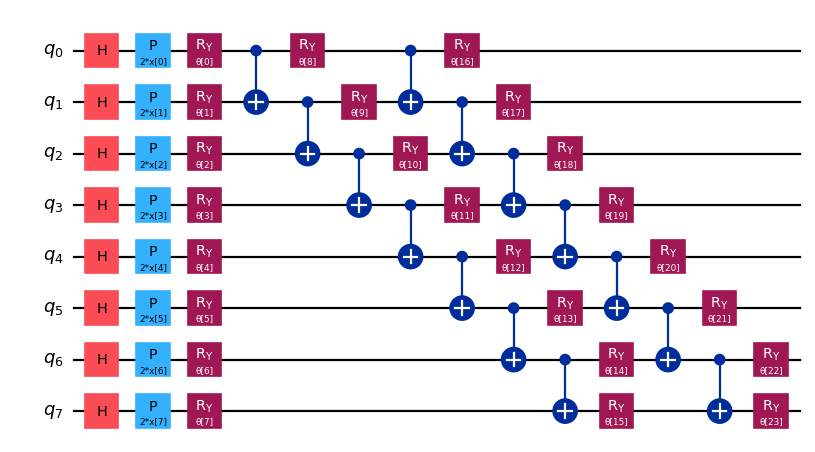

In [56]:
qc_pretty = qc.decompose()
qc_pretty = qc_pretty.decompose()  

qc_pretty.draw("mpl", fold=-1, scale=0.8)
